In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', serif='Arial') 
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
random_seed = 420
torch.manual_seed(random_seed)

In [6]:
from PIL import Image

im = np.array(Image.open('pearl_small.jpg'))
#im = np.delete(im, 0, axis=0)
im = np.mean(im, axis = 2)/25
print(im.shape)


(150, 150)


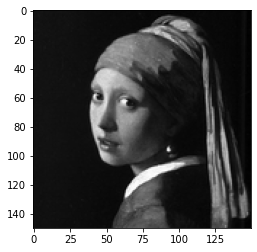

In [7]:
plt.imshow(im, cmap = 'gray')
plt.savefig('figures/paper/Fig4_original_image.png', dpi=300)

In [13]:
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)
    
class simple_encoder():
    def __init__(self, out_dim, in_dim, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return torch.matmul(self.W, X)
    
class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.epsilon = epsilon
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        print(self.W.dtype)
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
    def apply_wo_threshold(self, X):
        return torch.matmul(self.W, X)
    
def visualize(s, fname = None):
    fig = plt.figure()
    plt.imshow(s, cmap='gray', interpolation='none')
    if fname is not None:
        plt.savefig(fname, dpi=300)

torch.Size([150, 150])


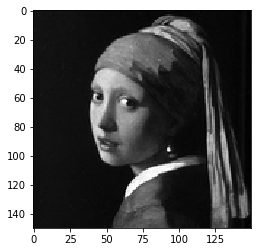

In [9]:
samples = torch.tensor(im, dtype = torch.float32)
print(samples.shape)
visualize(samples)

In [10]:
print(samples)

tensor([[0.8933, 0.8133, 0.8533,  ..., 0.2533, 0.1733, 0.1333],
        [0.9333, 0.8533, 0.8533,  ..., 0.2533, 0.1333, 0.2133],
        [0.8933, 0.8933, 0.7733,  ..., 0.2133, 0.1733, 0.1733],
        ...,
        [0.8133, 0.7733, 0.6933,  ..., 0.2133, 0.1600, 0.2133],
        [0.7733, 0.7333, 0.6933,  ..., 0.2533, 0.2133, 0.2133],
        [0.7733, 0.7333, 0.6933,  ..., 0.2133, 0.1333, 0.1733]])


In [11]:
l = samples.shape[0]
encoder = simple_encoder_wthreshold(l*l*25, l*l, 0,False)

torch.float32
torch.Size([562500])
torch.Size([750, 750])


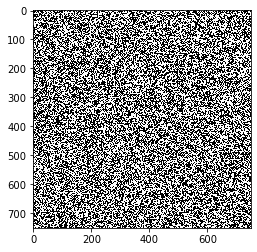

In [14]:
encoded_s = encoder.apply(samples.view(l*l))
print(encoded_s.shape)
encoded_s = encoded_s.T.view(l*5,l*5)
print(encoded_s.shape)
visualize(encoded_s, fname = 'figures/paper/Fig4_binarized_encrypted_image.png')

torch.Size([562500])
torch.Size([750, 750])


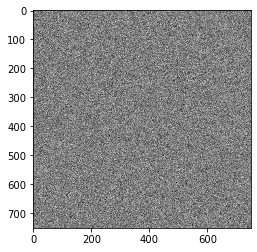

In [15]:
encoded_wo = encoder.apply_wo_threshold(samples.view(l*l))
print(encoded_wo.shape)
encoded_wo = encoded_wo.T.view(l*5,l*5)
print(encoded_wo.shape)
visualize(encoded_wo, fname = 'figures/paper/Fig4_hyper_encrypted_image.png')

In [17]:
count_black = np.sum(encoded_s.numpy()) #histogram(encoded_s[0], bins=3)
count_white = l*l*25 - count_black

281644.0 280856.0


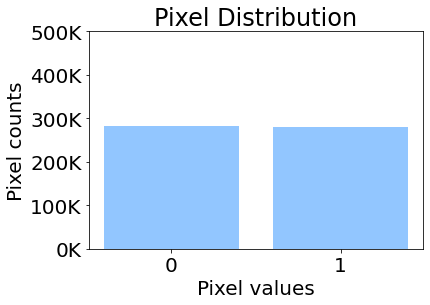

In [58]:
def format_number(data_value, indx):
    formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

ax = plt.axes()
ax.yaxis.set_major_formatter(format_number)

matplotlib.rcParams.update({'font.size': 20})
plt.style.use('seaborn-pastel')
print(count_black, count_white)
plt.ylim([0, 500000])
plt.title("Pixel Distribution")
plt.xlabel("Pixel values")
plt.ylabel("Pixel counts")
plt.bar(['0', '1'], [count_black, count_white])
plt.savefig('figures/paper/Fig4_pixel_distribution3.png', dpi=300, bbox_inches='tight')

<ipython-input-59-4b0d60b14671>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


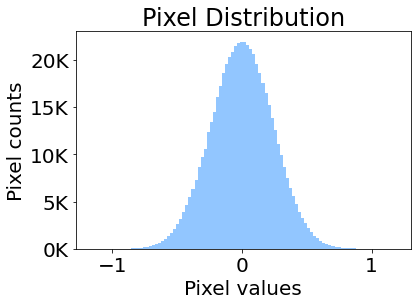

In [59]:
plt.title("Pixel Distribution")
plt.xlabel("Pixel values")
plt.ylabel("Pixel counts")
plt.hist(encoded_wo.flatten().numpy()/2000, 100)
ax = plt.axes()
ax.yaxis.set_major_formatter(format_number)
plt.savefig('figures/paper/Fig4_pixel_distribution2.png', dpi=300, bbox_inches='tight')

<ipython-input-60-2ea2f9d6879a>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


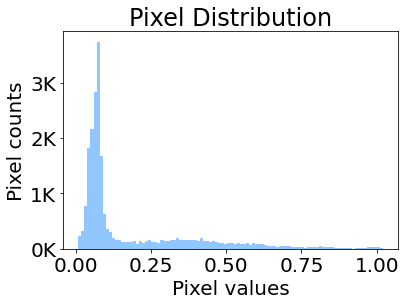

In [60]:
plt.title("Pixel Distribution")
plt.xlabel("Pixel values")
plt.ylabel("Pixel counts")
ax = plt.axes()
ax.yaxis.set_major_formatter(format_number)
plt.hist(samples.flatten().numpy()/10, 100)
plt.savefig('figures/paper/Fig4_pixel_distribution1.png', dpi=300, bbox_inches='tight')

In [63]:
def pixel_correlation_vertical(image):
    #image is WxH numpy array
    x = []
    y = []
    for i in range(W):
        for j in range(H-1):
            x = image[j][i]
            y = image[j+1][i]
    plt.scatter(x, y)
    
def pixel_correlation_adjacent(flattened_image, title = "Adjacent Pixels Correlation", fname = None):
    #image is WxH numpy array
    x = []
    y = []
    l = flattened_image.size
    for i in range(l-1):
            x.append(flattened_image[i])
            y.append(flattened_image[i+1])
    plt.title(title)
    plt.xlabel("Pixel values")
    plt.ylabel("Pixel values")
    plt.scatter(x, y, s = 0.1)
    if fname is not None:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    
def pixel_correlation_binary(flattened_image, fname = None):
    #image is WxH numpy array
    cate = [0,0,0,0]
    l = flattened_image.size
    for i in range(l-1):
        this = flattened_image[i]
        nex = flattened_image[i+1]
        if this == 1 and nex == 1:
            cate[0] +=1
        elif this == 1 and nex == 0:
            cate[1] +=1
        elif this == 0 and nex == 1:
            cate[2] +=1
        elif this == 0 and nex == 0:
            cate[3] +=1
    plt.ylim([0, 200000])
    ax = plt.axes()
    ax.yaxis.set_major_formatter(format_number)
    plt.title("Adjacent Pixels Correlation")
    plt.xlabel("Pixel values")
    plt.ylabel("Pixel counts")
    plt.bar(['1-1', '1-0', '0-1', '0-0'], cate)
    if fname is not None:
        plt.savefig(fname, dpi=300, bbox_inches='tight')

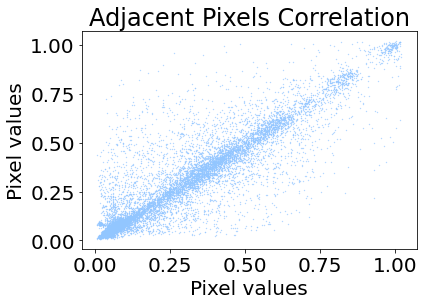

In [64]:
pixel_correlation_adjacent(samples.flatten().numpy()/10, fname = 'figures/paper/Fig4_pixel_correlation1_image.png')

<ipython-input-63-c61648e8ba6b>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


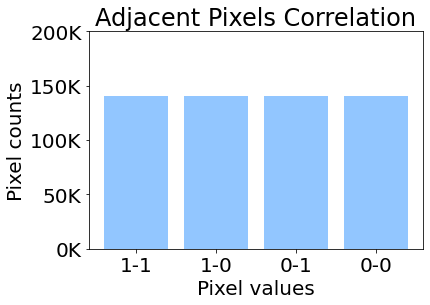

In [65]:
pixel_correlation_binary(encoded_s.flatten().numpy(), fname = 'figures/paper/Fig4_pixel_correlation3_image.png')

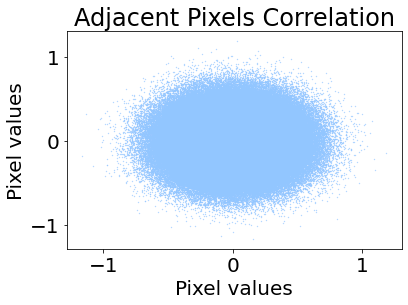

In [66]:
pixel_correlation_adjacent(encoded_wo.flatten().numpy()/2000, "Adjacent Pixels Correlation", fname = 'figures/paper/Fig4_pixel_correlation2_image.png')